# Ma511 Deep Learning for Image Processing - Project : Satellite Image Classification

Group : Paul LEDERMANN | Class : CDI

This notebook explores the classification of satellite images using deep learning techniques. The dataset includes images from two satellite sources: Sentinel-1 and Sentinel-2. The goal is to build separate models for each satellite and then combine their predictions for improved classification accuracy.

Notebook Structure:
- Data Loading
- Data Exploration : visualization of the data, understanding of the data
- Deep Learning on Sentinel-1 Imagery : Data preprocessing, CNN Model creation, Optimization of the model, Performance analysis
- Deep Learning on Sentinel-2 Imagery : Data preprocessing, CNN Model creation, Optimization of the model, Performance analysis
- Saving the model into h5 file
- Computation of the Sentinel-1 and Sentinel-2 DL models predictions to make a better final prediction

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imageio

# Data Loading

In [2]:
# Set the paths to the data folders
s1_folder = "s1_60m"
s2_folder = "s2_60m"
labels_folder = "labels"

# Load the filenames for training and testing
train_filenames = np.loadtxt("train_filenames.lst", dtype=str)
test_filenames = np.loadtxt("test_filenames.lst", dtype=str)

In [3]:
# Function to load images from folder
def load_images(folder, filenames):
    images = []
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = imageio.imread(img_path)
        images.append(img)
    return images

# Load Sentinel-1 (SAR) and Sentinel-2 (optical) images
s1_images = load_images(s1_folder, train_filenames)
s2_images = load_images(s2_folder, train_filenames)

labels_path = "labels/TreeSatBA_v9_60m_multi_labels.json"

with open(labels_path, 'r') as f:
    labels_data = json.load(f)

C:\Users\yanis\AppData\Local\Temp\ipykernel_17824\1898513816.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


# Data Exploration

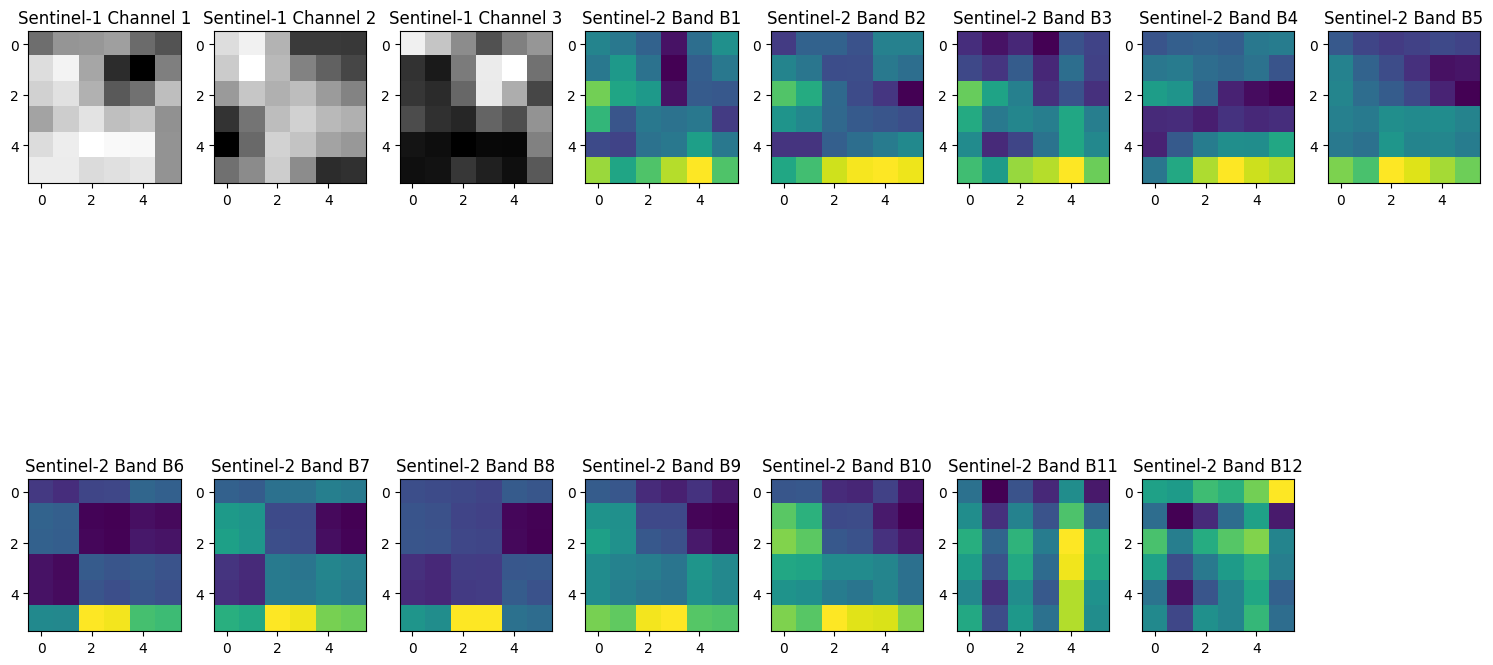

In [7]:
# Visualize all channels for one patch of Sentinel-1 and Sentinel-2
patch_index = 0  # Change the patch index to visualize different patches

plt.figure(figsize=(15, 10))

# Sentinel-1 visualization
for i in range(3):  # Three channels in Sentinel-1
    plt.subplot(2, 8, i + 1)
    plt.imshow(s1_images[patch_index][:, :, i], cmap='gray')
    plt.title(f'Sentinel-1 Channel {i+1}')

# Sentinel-2 visualization
for i in range(12):  # Twelve channels in Sentinel-2
    plt.subplot(2, 8, i + 4)
    plt.imshow(s2_images[patch_index][:, :, i], cmap='viridis')  # You can change the colormap
    plt.title(f'Sentinel-2 Band B{i+1}')

plt.tight_layout()
plt.show()


As we can see above, the Sentinel-1 has 3 channels of 6x6 images, and the Sentinel-2 has 12 channels of 6x6 images.

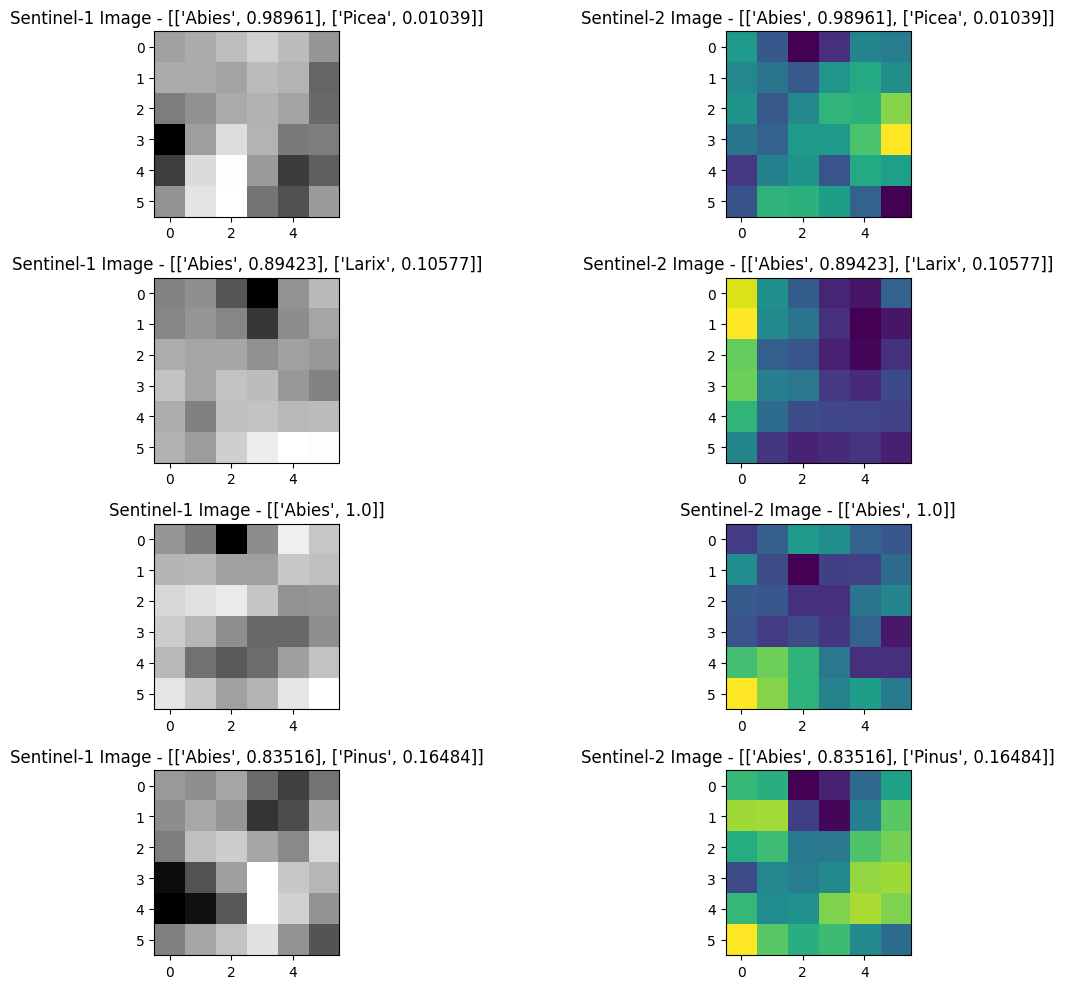

In [16]:
def extract_labels(filename, labels_data):
    return labels_data[filename]

plt.figure(figsize=(15, 10))
example_indices = [10, 100, 250, 300]
num_examples=len(example_indices)

for i, idx in enumerate(example_indices):
    s1_img = s1_images[idx]
    s2_img = s2_images[idx]
    label_info = extract_labels(train_filenames[idx], labels_data)
    
    plt.subplot(num_examples, 2, 2*i + 1)
    plt.imshow(s1_img[:, :, 0], cmap='gray')  # Displaying the first band of Sentinel-1
    plt.title(f'Sentinel-1 Image - {label_info}')
    
    plt.subplot(num_examples, 2, 2*i + 2)
    plt.imshow(s2_img[:, :, 3], cmap='viridis')  # Displaying a band of Sentinel-2 (B08 for example)
    plt.title(f'Sentinel-2 Image - {label_info}')

plt.tight_layout()
plt.show()

Here's an example of different images for Sentinel-1 and Sentinel-2, with their labels associated (the tree species present in the picture) and their respective proportions (between 0 and 1).

In [57]:
# Sizes of images
print(f"Size of Sentinel-1 images: {len(s1_images)}")
print(f"Size of Sentinel-2 images: {len(s2_images)}")

# Example filenames
print("\nExample filenames:")
print(f"Sentinel-1 example filename: {train_filenames[0]}")
print(f"Sentinel-2 example filename: {train_filenames[0]}")

# Distribution of labels
label_counts = {}
for filename in train_filenames:
    labels = extract_labels(filename, labels_data)
    for label, proportion in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

print("\nLabel distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count} occurrences")

Size of Sentinel-1 images: 45337
Size of Sentinel-2 images: 45337

Example filenames:
Sentinel-1 example filename: Abies_alba_0_2545_WEFL_NLF.tif
Sentinel-2 example filename: Abies_alba_0_2545_WEFL_NLF.tif

Label distribution:
Abies: 1454 occurrences
Quercus: 13967 occurrences
Picea: 12750 occurrences
Fagus: 12944 occurrences
Larix: 5739 occurrences
Pinus: 12377 occurrences
Pseudotsuga: 5179 occurrences
Cleared: 6365 occurrences
Acer: 3429 occurrences
Betula: 3903 occurrences
Populus: 584 occurrences
Alnus: 3787 occurrences
Fraxinus: 3040 occurrences
Prunus: 435 occurrences
Tilia: 257 occurrences


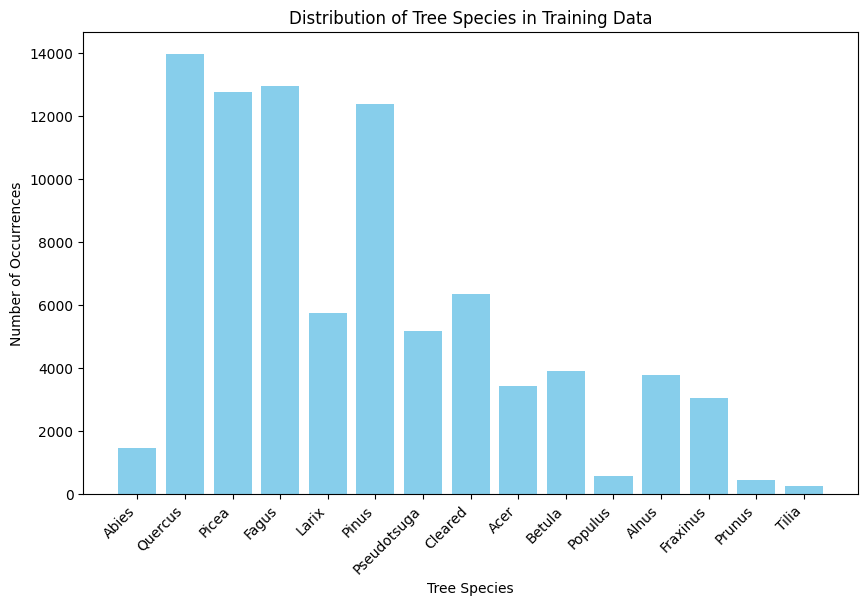

In [18]:
import matplotlib.pyplot as plt

# Distribution of labels
label_counts = {}
for filename in train_filenames:
    labels = extract_labels(filename, labels_data)
    for label, proportion in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

# Plot bar chart
labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Tree Species')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Tree Species in Training Data')
plt.xticks(rotation=45, ha='right')
plt.show()

# Sentinel-1

Let's start by working on the Sentinel-1 imagery.

## Data Preprocessing : Normalization, Shaping, Splitting

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Extract labels for Sentinel-1
y_s1 = [extract_labels(filename, labels_data) for filename in train_filenames]

# Flatten the data for Sentinel-1 so we can normalize it with the standard scaler
X_s1 = np.array([image.flatten() for image in s1_images])

# Normalize the data
scaler = StandardScaler()
X_s1 = np.array(scaler.fit_transform(X_s1))

# Reshape the training data to match the model's input shape
X_s1 = X_s1.reshape(-1, 6, 6, 3)

# Extract and encode the primary label for multiclass classification
y_s1_primary_labels = [label[0][0] for label in y_s1]  # Note the change here

# Map labels to integers
label_to_int = {label: i for i, label in enumerate(np.unique(y_s1_primary_labels))}
y_s1_encoded = to_categorical([label_to_int[label] for label in y_s1_primary_labels], num_classes=len(label_to_int))

# Split the data into training and testing sets
X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(X_s1, y_s1_encoded, test_size=0.1, random_state=42)

## Creation of a CNN model

In [32]:
# Create a CNN model for Sentinel-1
model_s1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(6, 6, 3), padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((1, 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(label_counts), activation='softmax')
])

## Training of the first model

In [33]:
# Compile the model
model_s1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_s1.fit(X_train_s1, y_train_s1, epochs=500, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/500
1148/1148 [==============================] - 5s 3ms/step - loss: 2.2925 - accuracy: 0.2484 - val_loss: 2.2332 - val_accuracy: 0.2801
Epoch 2/500
1148/1148 [==============================] - 4s 4ms/step - loss: 2.2245 - accuracy: 0.2705 - val_loss: 2.2239 - val_accuracy: 0.2825
Epoch 3/500
1148/1148 [==============================] - 4s 4ms/step - loss: 2.2039 - accuracy: 0.2760 - val_loss: 2.1887 - val_accuracy: 0.2845
Epoch 4/500
1148/1148 [==============================] - 3s 3ms/step - loss: 2.1943 - accuracy: 0.2778 - val_loss: 2.1822 - val_accuracy: 0.2963
Epoch 5/500
1148/1148 [==============================] - 4s 3ms/step - loss: 2.1856 - accuracy: 0.2810 - val_loss: 2.1939 - val_accuracy: 0.2840
Epoch 6/500
1148/1148 [==============================] - 3s 3ms/step - loss: 2.1810 - accuracy: 0.2813 - val_loss: 2.2023 - val_accuracy: 0.2918
Epoch 7/500
1148/1148 [==============================] - 3s 3ms/step - loss: 2.1729 - accuracy: 0.2850 - val_loss: 2.2055 - val_ac

Test Accuracy for Sentinel-1 Model: 21.92%


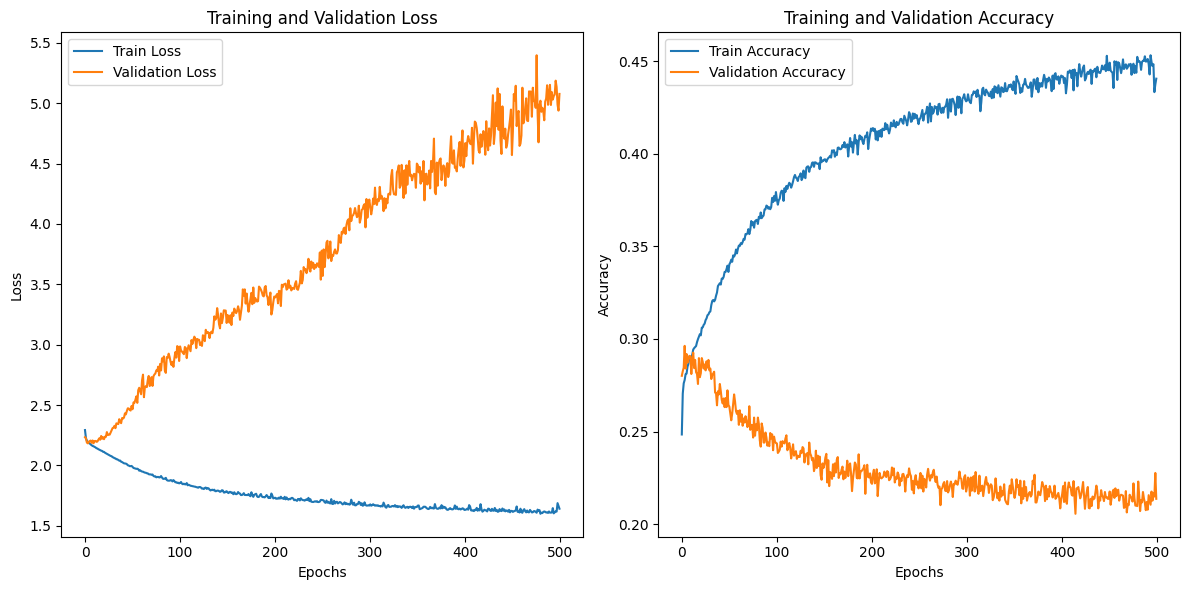

In [36]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_s1.evaluate(X_test_s1, y_test_s1, verbose=0)
print(f"Test Accuracy for Sentinel-1 Model: {test_accuracy*100:.2f}%")

# Plot training history for loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training history for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


We can see that the model is clearly and hardly overfitting. Let's try to apply some changes in our model.

## Creation of a second CNN model (with dropouts)

We add dropouts in our model in order to try to reduce the overfitting and obtain good results.

In [39]:
from keras.layers import Dropout

model_s1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(6, 6, 3), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((1, 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_counts), activation='softmax')
])


In [75]:
# Display the model's architecture
model_s1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 6, 6, 32)          896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 1, 64)          18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 64)               

## Training of the second model (with early stopping)

In [41]:
from keras.callbacks import EarlyStopping

model_s1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_s1.fit(X_train_s1, y_train_s1, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/100
1148/1148 [==============================] - 6s 4ms/step - loss: 2.3635 - accuracy: 0.2266 - val_loss: 2.2615 - val_accuracy: 0.2732
Epoch 2/100
1148/1148 [==============================] - 4s 4ms/step - loss: 2.2803 - accuracy: 0.2547 - val_loss: 2.2191 - val_accuracy: 0.2779
Epoch 3/100
1148/1148 [==============================] - 4s 4ms/step - loss: 2.2569 - accuracy: 0.2608 - val_loss: 2.2148 - val_accuracy: 0.2781
Epoch 4/100
1148/1148 [==============================] - 4s 4ms/step - loss: 2.2466 - accuracy: 0.2647 - val_loss: 2.2006 - val_accuracy: 0.2803
Epoch 5/100
1148/1148 [==============================] - 4s 4ms/step - loss: 2.2366 - accuracy: 0.2675 - val_loss: 2.2059 - val_accuracy: 0.2862
Epoch 6/100
1148/1148 [==============================] - 4s 4ms/step - loss: 2.2336 - accuracy: 0.2683 - val_loss: 2.1932 - val_accuracy: 0.2882
Epoch 7/100
1148/1148 [==============================] - 4s 4ms/step - loss: 2.2271 - accuracy: 0.2705 - val_loss: 2.1968 - val_ac

Test Accuracy for Sentinel-1 Model: 29.00%


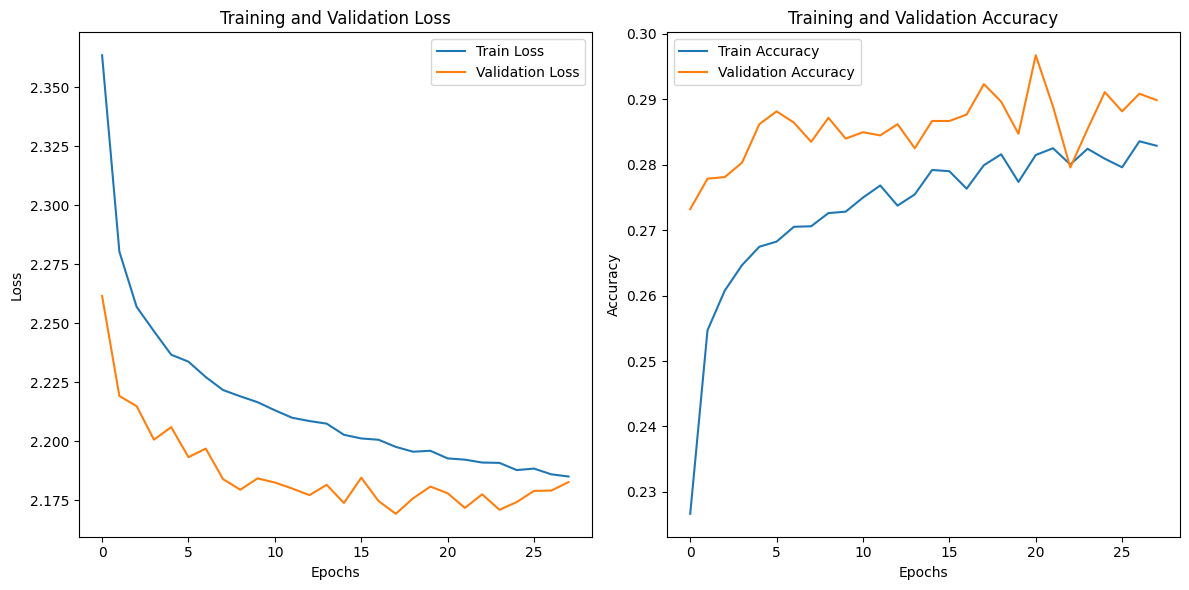

In [42]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_s1.evaluate(X_test_s1, y_test_s1, verbose=0)
print(f"Test Accuracy for Sentinel-1 Model: {test_accuracy*100:.2f}%")

# Plot training history for loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training history for accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The loss (categorical crossentropy) and the accuracy of the model seem to be fine, showing no overfitting this time. It looks like we cannot go higher than 30% of accuracy for this model and for Sentinel-1 imagery.

# Sentinel-2

Now we obtained results on Sentinel-1 imagery, let's work on the Sentinel-2 imagery.

## Data Preprocessing : Normalization, Shaping, Splitting

In [43]:
# Extract labels for Sentinel-1
y_s2 = [extract_labels(filename, labels_data) for filename in train_filenames]

# Flatten the data for Sentinel-1
X_s2 = np.array([image.flatten() for image in s2_images])

# Normalize the data
scaler = StandardScaler()
X_s2 = np.array(scaler.fit_transform(X_s2))

# Reshape the training data to match the model's input shape
X_s2 = X_s2.reshape(-1, 6, 6, 12)

# Extract and encode the primary label for multiclass classification
y_s2_primary_labels = [label[0][0] for label in y_s2]  # Note the change here

# Map labels to integers
label_to_int = {label: i for i, label in enumerate(np.unique(y_s2_primary_labels))}
y_s2_encoded = to_categorical([label_to_int[label] for label in y_s2_primary_labels], num_classes=len(label_to_int))

# Split the data into training and testing sets
X_train_s2, X_test_s2, y_train_s2, y_test_s2 = train_test_split(X_s2, y_s2_encoded, test_size=0.1, random_state=42)

## Creation of a CNN model (with dropout)

In [53]:
model_s2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(6, 6, 12), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((1, 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_counts), activation='softmax')
])

In [73]:
# Display the model's architecture
model_s2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 6, 6, 32)          3488      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 3, 3, 32)          0         
 ng2D)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 3, 3, 32)          0         
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 1, 64)          18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 1, 1, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 64)               

## Training (with early stopping)

In [54]:
model_s2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_s2 = model_s2.fit(X_train_s2, y_train_s2, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/100
1148/1148 [==============================] - 6s 4ms/step - loss: 1.8017 - accuracy: 0.4485 - val_loss: 1.5164 - val_accuracy: 0.5183
Epoch 2/100
1148/1148 [==============================] - 5s 4ms/step - loss: 1.5825 - accuracy: 0.5167 - val_loss: 1.4114 - val_accuracy: 0.5553
Epoch 3/100
1148/1148 [==============================] - 5s 4ms/step - loss: 1.5058 - accuracy: 0.5353 - val_loss: 1.3691 - val_accuracy: 0.5682
Epoch 4/100
1148/1148 [==============================] - 5s 4ms/step - loss: 1.4620 - accuracy: 0.5483 - val_loss: 1.3532 - val_accuracy: 0.5714
Epoch 5/100
1148/1148 [==============================] - 5s 4ms/step - loss: 1.4339 - accuracy: 0.5572 - val_loss: 1.3364 - val_accuracy: 0.5756
Epoch 6/100
1148/1148 [==============================] - 5s 4ms/step - loss: 1.4129 - accuracy: 0.5621 - val_loss: 1.3156 - val_accuracy: 0.5839
Epoch 7/100
1148/1148 [==============================] - 5s 4ms/step - loss: 1.3871 - accuracy: 0.5712 - val_loss: 1.2768 - val_ac

Test Accuracy for Sentinel-2 Model: 60.61%


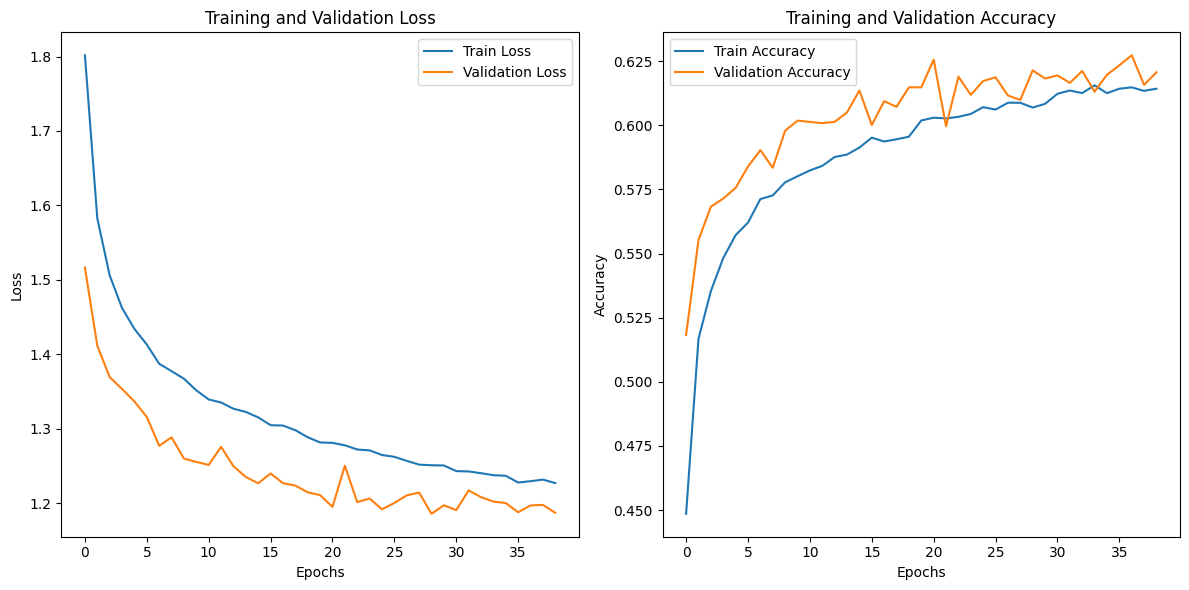

In [55]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_s2.evaluate(X_test_s2, y_test_s2, verbose=0)
print(f"Test Accuracy for Sentinel-2 Model: {test_accuracy*100:.2f}%")

# Plot training history for loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_s2.history['loss'], label='Train Loss')
plt.plot(history_s2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training history for accuracy
plt.subplot(1, 2, 2)
plt.plot(history_s2.history['accuracy'], label='Train Accuracy')
plt.plot(history_s2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The loss (categorical crossentropy) and the accuracy of the model seem to be fine, showing no overfitting for the model. The performance of the model on Sentinel-2 imagery shows better scores than Sentinel-1.

# Saving the model

In [76]:
model_s2.save('model_s2.h5')

c:\Users\yanis\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Computation of Sentinel-1 and Sentinel-2 predicitions

Let's try to compute Sentinel-1 and Sentinel-2 predictions, using their model performance accuracy as weight in order to make a final predictions, which should be better than the two first of S1 and S2.

In [70]:
# Models performances
accuracy_s1 = 0.2900
accuracy_s2 = 0.6061

# Normalisation des performances pour obtenir des poids (plus le modèle est performant, plus son poids est élevé)
weight_s1 = accuracy_s1 / (accuracy_s1 + accuracy_s2)
weight_s2 = accuracy_s2 / (accuracy_s1 + accuracy_s2)

# Prédiction sur les données de test
predictions_s1 = model_s1.predict(X_test_s1)
predictions_s2 = model_s2.predict(X_test_s2)

# Combinaison des prédictions en utilisant une moyenne pondérée
final_predictions_proba = (weight_s1 * predictions_s1 + weight_s2 * predictions_s2) / 2

# Sélection de la classe avec la probabilité la plus élevée comme prédiction finale
final_predictions = np.argmax(final_predictions_proba, axis=1)

# Affichage des résultats
print("Final Predictions Proba:", final_predictions_proba)
print("Final Predictions:", final_predictions)

142/142 [==============================] - 0s 2ms/step
Final Predictions Proba: [[3.0336059e-03 7.7271881e-03 5.3456044e-03 ... 6.7816917e-03
  1.6622063e-02 7.7420977e-05]
 [2.8638830e-03 1.1382824e-03 4.4372790e-03 ... 7.8210337e-03
  1.0558594e-02 3.8320399e-05]
 [2.7842548e-02 1.8941596e-02 3.3792950e-02 ... 2.7004927e-02
  8.2352474e-02 1.1426335e-03]
 ...
 [1.4117541e-02 2.0711194e-03 9.3413461e-03 ... 4.5899551e-02
  2.8611742e-02 8.0500344e-05]
 [5.1827328e-03 8.2548410e-03 1.1129359e-02 ... 2.6346916e-02
  3.1629998e-02 5.3320726e-04]
 [2.8193330e-03 6.8502678e-03 9.1172447e-03 ... 1.1742426e-02
  2.2633843e-02 8.1813877e-04]]
Final Predictions: [ 5  9 13 ...  9  8  8]


Let's calculate the accuracy of this final prediction

In [71]:
from sklearn.metrics import accuracy_score

# Sélection de la classe avec la probabilité la plus élevée comme prédiction finale
# y_test_s1 = np.argmax(y_test_s1, axis=1)

# Calcul de l'accuracy pour la prédiction finale
accuracy_final = accuracy_score(y_test_s1, final_predictions)

print(f"Accuracy of the Final Prediction: {100*round(accuracy_final,4)}%")

Accuracy of the Final Prediction: 61.51%


We have a final prediction which is better than each of our Sentinel-1 and Sentinel-2 models predictions, so the computation is significant.